# Traning

Traning Spaceship-Titanic model.

This notebook will use MLflow to track the model training process.

## MLflow

Install MLflow with pip:

```bash
pip install mlflow
```

Run the following command in the **root directory of the project** to start the MLflow server:

```bash
mlflow server --port 8000
```

## Data

Note: the `train.csv` is the unique dataset that has the target column (**Transported**).

Because of that, we will split the data into train and test datasets. The test dataset will be used to evaluate the model after training.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('data/spaceshit-titanic/train.csv')

X, y = data.drop('Transported', axis=1), data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


## Pipeline building

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Columns separation
# Categorical columns
categorical_columns = [
    'Group', # it will be created by the passenger_id_spliter
    'Deck', # it will be created by the cabin_spliter
    'Num', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]
# Categorical columns to encode. They have low cardinality
columns_to_encode = [
    'Deck', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]

# Numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

## 2. FunctionTransformers. Custom transformers for columns
# Function
def passenger_id_spliter(passenger_id_col: pd.Series) -> pd.DataFrame:
    '''Function to split the passenger id into two columns

    Args:
        passenger_id_col: pd.Series - The passenger id column

    Returns:
        pd.DataFrame - The dataframe with the two columns (Group, Number)
    '''
    df = (
        pd.DataFrame(
            passenger_id_col
            .str
            .split('_')
            .to_list(),
        columns=['Group', 'Number'],
        index=passenger_id_col.index
        )
        .drop('Number', axis=1)
    )
    return df

def cabin_spliter(cabin_col: pd.Series) -> pd.DataFrame:
    '''Function to split the cabin into two columns

    Args:
        cabin_col: pd.Series - The cabin column

    Returns:
        pd.DataFrame - The dataframe with three columns (Deck, Num, Side)
    '''
    df = (
        cabin_col
        .str
        .split('/', expand=True)
        .rename(columns={0: 'Deck', 1: 'Num', 2: 'Side'})
    )

    return df

## 3. Transformer instantiation

# Custom transformers
passenger_id_transformer = FunctionTransformer(func=passenger_id_spliter,
    feature_names_out=lambda _, __: np.array(['Group'])
)

cabin_transformer = FunctionTransformer(func=cabin_spliter,
    feature_names_out=lambda _, __: np.array(['Deck', 'Num', 'Side'])
)

# Encoders
encoder = OrdinalEncoder()
one_hot = OneHotEncoder()

# Scalers
scaler = StandardScaler()

# Imputer
knn = KNNImputer(n_neighbors=10, weights='uniform')
simple_imputer = SimpleImputer(strategy='median')

# Rounder for the categorical columns
rounder = FunctionTransformer(func=lambda x: np.round(x, 0),
    feature_names_out=lambda _, __: categorical_columns
)

## 4. Transformers pipeline

# Columns splitter function transformer
splitter_transformer = ColumnTransformer(
    transformers=[
        ('passenger_id', passenger_id_transformer, 'PassengerId'),
        ('cabin', cabin_transformer, 'Cabin')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Enconder the categorical columns
encoder_transfomer = ColumnTransformer(
    transformers=[
        ('encoder', encoder, columns_to_encode)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Imputers and dropping high cardinality columns
imputer_transformer = ColumnTransformer(
    transformers=[
        ('numeric_imputer', simple_imputer, numeric_columns),
        ('categorical_imputer', knn, categorical_columns)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Rounder and scalers
rounder_scaler_transformer = ColumnTransformer(
    transformers=[
        ('rounder', rounder, categorical_columns),
        ('scaler', scaler, numeric_columns)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Dropping columns
drop_columns_transformer = ColumnTransformer(
    transformers=[
        ('drop', 'drop', 'Name')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Gather all transformers into a pipeline
transfomers = Pipeline([
    ('splitter', splitter_transformer),
    ('encoder', encoder_transfomer),
    ('imputer', imputer_transformer),
    ('rounder_scaler', rounder_scaler_transformer),
    ('drop_columns', drop_columns_transformer)
])

# Garantee that the output of "transform" and "fit_transform" will be a pandas dataframe
# This is necessary due use label columns into transformers
transfomers.set_output(transform='pandas')

# Estimator to predict.
# They can be chaged in the clf pipeline estimator step
nn = MLPClassifier(hidden_layer_sizes=(50, 5), activation='relu', max_iter=1000, random_state=42)
logistic = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Pipeline
clf = Pipeline([
    ('estimator', nn)
])

# 5. Final pipeline
pipe = Pipeline([
    ('transformers', transfomers),
    ('clf', clf)
])

pipe.fit(X_train, y_train)

c:\Users\ismae\OneDrive\Cursos\AI ML DS CMU\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformers',
                 Pipeline(steps=[('splitter',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('passenger_id',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x000001B75A685760>,
                                                                                       func=<function passenger_id_spliter at 0x000001B75A6858A0>),
                                                                   'PassengerId'),
                                                                  ('cabin',
                                                                   FunctionTransformer(feature_n...
                                                                   Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object'))],
                                                    verbose_feature_names_out=False)),
                                 ('drop_columns',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   'Name')],
                                                    verbose_feature_names_out=False))])),
                ('clf',
                 Pipeline(steps=[('estimator',
                                  LogisticRegression(random_state=42))]))])

## Running experiments in MLflow

Before running the following cells, make sure the MLflow server is running.

Run the command below in the root directory of the project:

```bash
mlflow server --port 8000
```

Access the MLflow UI by navigating to http://localhost:8000 in your web browser.

In [ ]:
import datetime
import mlflow

# Set the MLflow server
mlflow.set_tracking_uri('http://localhost:8000')

# Set the experiment, or create and set if not exists
mlflow.set_experiment('spaceshit-titanic')

<Experiment: artifact_location='mlflow-artifacts:/247830321258610220', creation_time=1733681399831, experiment_id='247830321258610220', last_update_time=1733681399831, lifecycle_stage='active', name='spaceshit-titanic', tags={}>

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

c:\Users\ismae\OneDrive\Cursos\AI ML DS CMU\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/12/08 18:16:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\ismae\OneDrive\Cursos\AI ML DS CMU\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale t

🏃 View run spaceshit-titanic-20241208-181618 at: http://localhost:8000/#/experiments/247830321258610220/runs/e316c25e1103403382776470786f6db6
🧪 View experiment at: http://localhost:8000/#/experiments/247830321258610220


c:\Users\ismae\OneDrive\Cursos\AI ML DS CMU\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


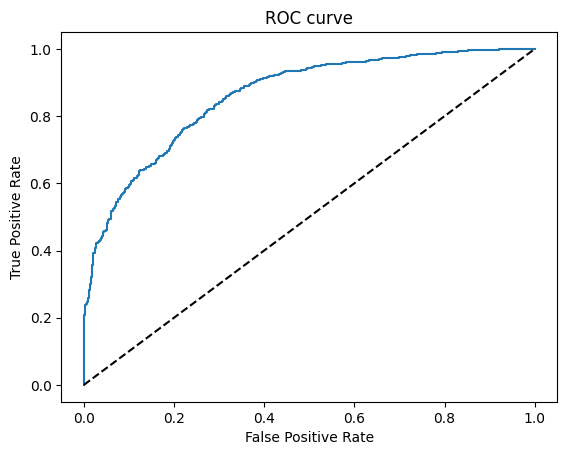

In [ ]:
label = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# Run in mlflow
with mlflow.start_run(run_name=f"spaceshit-titanic-{label}"):

    mlflow.set_tag('Project', 'spaceshit-titanic')

    # Logar os parametros
    params = pipe.get_params(deep=True)
    params.pop('memory', {})

    mlflow.log_params(params)
    mlflow

    # Pipeline fit
    pipe.fit(X_train, y_train)

    # Export the html of the pipeline
    artifacts_temp = 'artifacts_temp'

    with open(f'{artifacts_temp}/pipeline.html', 'w', encoding='utf8') as file:
        file.write(pipe._repr_html_()) #type: ignore
    
    mlflow.log_artifact(f'{artifacts_temp}/pipeline.html', 'pipeline')


    mlflow.sklearn.log_model(sk_model=pipe,
                             artifact_path='spaceshit-titanic-model',
                            # registered_model_name=f'spaceshit-titanic'
    )

    # Metrics
    fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig(f'{artifacts_temp}/roc_curve.png')

    mlflow.log_artifact(f'{artifacts_temp}/roc_curve.png', 'metrics')
    
    roc_auc_score_ = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])

    mlflow.log_metric('roc_auc', roc_auc_score_)

    cv_accuracy = cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy')
    mlflow.log_metric('cross_val_accuracy_mean', cv_accuracy.mean())
    cv_recall = cross_val_score(pipe, X_train, y_train, cv=10, scoring='recall')
    mlflow.log_metric('cross_val_recall_mean', cv_recall.mean())
    cv_precision = cross_val_score(pipe, X_train, y_train, cv=10, scoring='precision')
    mlflow.log_metric('cross_val_precision', cv_precision.mean())

    
    # # Log the dataset
    # X.to_csv('artifacts_temp/X.json', index=False)
    # mlflow.log_artifact('artifacts_temp/X.csv', 'spaceshit-titanic-data')

    # dataset: PandasDataset = mlflow.data.from_pandas(X, source='artifacts_temp/X.csv')
    # mlflow.log_input(dataset, context='train')